# Análisis de Vecino mas Cercano

Los SIG nos permiten analizar las relaciones espaciales que existen en la información geográfica. Uno de estos análisis es identificar que objetos espaciales están mas cerca uno de otro. En este tutorial vamos a replicar esta herramienta utilizando **Python** y sus librerías **[#geopandas](https://geopandas.org/en/stable/)** y **[#shapely](https://shapely.readthedocs.io/en/stable/manual.html)**.

## Objetivos

* El objetivo es identificar la comisaria mas cercana a cada una de las instituciones educativas de la provincia de Ica.

## Obtener los datos

Para este tutorial descargamos los conjuntos de datos de las siguientes fuentes:

* Comisarias: [Directorios de comisarias](https://www.mininter.gob.pe/ubica-tu-comisaria) del Ministerio del Interio del Perú
* Instituciones educativas: [Estadisticas de la calidad educativa](https://escale.minedu.gob.pe/padron-de-iiee) del Ministerio de Educación del Perú

## Procedimiento

### 1. Preparación de los datos

Importaremos los modulos a utilizar

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point

A continuación, vamos a leer los conjuntos de datos que utilizaremos. Las comisarias se encuentran en formato Shapefile y las instituciones educativas en valores separador por coma (csv).

In [2]:
# Lectura de comisarias
gdfComisarias = gpd.read_file('data/comisarias_peru.shp')

# Lectura de colegios
dfColegios = pd.read_csv('data/Padron_web.csv', encoding='UTF-8', sep=';', low_memory=False)

Visualizaremos los datos:

In [3]:
# Visualizar comisarias
gdfComisarias.head(3)

,id,nombre,departamen,provincia,distrito,ubigeo,lon,lat,geometry
0,32,COMISARIA INDIANA,LORETO,MAYNAS,INDIANA,160104,-73.042052,-3.499631,POINT (-73.04205 -3.49963)
1,33,COMISARIA RURAL SINCHICUY,LORETO,MAYNAS,INDIANA,160104,-73.139910,-3.588879,POINT (-73.13991 -3.58888)
2,34,COMISARIA FRANCISCO DE ORELLANA,LORETO,MAYNAS,LAS AMAZONAS,160105,-72.764743,-3.422353,POINT (-72.76474 -3.42235)


La capa de colegios contiene muchas columnas, vamos a listar los nombres para visualizar solo las columnas que contienen las coordenadas.

In [4]:
# Listado de columnas de colegios
dfColegios.columns.values

array(['COD_MOD', 'ANEXO', 'CODLOCAL', 'CEN_EDU', 'NIV_MOD', 'D_NIV_MOD',
       'D_FORMA', 'COD_CAR', 'D_COD_CAR', 'TIPSSEXO', 'D_TIPSSEXO',
       'GESTION', 'D_GESTION', 'GES_DEP', 'D_GES_DEP', 'DIRECTOR',
       'TELEFONO', 'EMAIL', 'PAGWEB', 'DIR_CEN', 'REFERENCIA',
       'LOCALIDAD', 'CODCP_INEI', 'CODCCPP', 'CEN_POB', 'AREA_CENSO',
       'DAREACENSO', 'CODGEO', 'D_DPTO', 'D_PROV', 'D_DIST', 'D_REGION',
       'CODOOII', 'D_DREUGEL', 'NLAT_IE', 'NLONG_IE', 'TIPOPROG',
       'D_TIPOPROG', 'COD_TUR', 'D_COD_TUR', 'ESTADO', 'D_ESTADO',
       'D_FTE_DATO', 'TALUM_HOM', 'TALUM_MUJ', 'TALUMNO', 'TDOCENTE',
       'TSECCION', 'FECHAREG', 'FECHA_ACT'], dtype=object)

In [5]:
# Visualizar coordenadas de colegios
dfColegios[['NLAT_IE', 'NLONG_IE']].head(3)

,NLAT_IE,NLONG_IE
0,-9.51885,-77.53191
1,-9.53067,-77.53196
2,-9.53110,-77.52270


Observamos que las coordenadas estan expresadas grados decimales en el Sistema de Referencia geodésico WGS84 (EPSG: 4326).

Utilizando la clase **[geopandas.GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html)** y el método **[geopandas.points_from_xy](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html)** realizaremos la conversion de las instituciones educativas de DataFrame a GeoDataFrame.

In [6]:
# Crear arreglo de geometrias con points_from_xy
geometry = gpd.points_from_xy(x=dfColegios.NLONG_IE, y=dfColegios.NLAT_IE, crs="EPSG:4326")
print(f'Tipo de dato: {type(geometry)}')

Tipo de dato: <class 'geopandas.array.GeometryArray'>


In [7]:
# Convertir DataFrame a GeoDataFrame
gdfColegios = gpd.GeoDataFrame(dfColegios, geometry=geometry)
print(f'Tipo de dato: {type(gdfColegios)}')

Tipo de dato: <class 'geopandas.geodataframe.GeoDataFrame'>


In [8]:
# Visualizar GeoDataFrame
gdfColegios[['NLAT_IE', 'NLONG_IE', 'geometry']].head()

,NLAT_IE,NLONG_IE,geometry
0,-9.518850,-77.531910,POINT (-77.53191 -9.51885)
1,-9.530670,-77.531960,POINT (-77.53196 -9.53067)
2,-9.531100,-77.522700,POINT (-77.52270 -9.53110)
3,-9.516673,-77.531481,POINT (-77.53148 -9.51667)
4,-9.513940,-77.504026,POINT (-77.50403 -9.51394)


Como solo necesitamos los datos de la provincia de **Ica** vamos a filtrar nuestros datos para esta provincia.

In [9]:
# Filtrar comisarias
gdfComisariasIca = gdfComisarias.loc[gdfComisarias.provincia=='ICA']
gdfComisariasIca.shape

(15, 9)

In [10]:
# Filtrar colegios
gdfColegiosIca = gdfColegios.loc[gdfColegios.D_PROV=='ICA']
gdfColegiosIca.shape

(1880, 51)

Proyectar la capa a WGS84 Zona 18 Sur (**EPSG:32718**)

In [11]:
gdfComisariasIca = gdfComisariasIca.to_crs(epsg=32718)
gdfColegiosIca = gdfColegiosIca.to_crs(epsg=32718)

Verificar la proyección de ambas capas:

In [12]:
# Verificar la geometria de las comisarias
gdfComisariasIca['geometry'].head(3)

1230    POINT (420968.872 8444929.856)
1231    POINT (420898.832 8444421.778)
1232    POINT (423270.684 8448107.866)
Name: geometry, dtype: geometry

In [13]:
# Verificar la geometria de los colegios
gdfColegiosIca['geometry'].head(3)

20230    POINT (419160.181 8446071.519)
20231    POINT (419153.412 8443919.343)
20232    POINT (420587.574 8441757.110)
Name: geometry, dtype: geometry

### 2. Análisis del Vecino mas cercano

Utilizando la función shapely **[nearest_points](https://shapely.readthedocs.io/en/stable/manual.html#shapely.ops.nearest_points)**  vamos a crear una función que nos permita calcular el vecino mas cercanos entre dos GeoDataFrames.

La función **nearest_points** retorna una tupla con el par de puntos (**origen, destino**) mas cercanos entre sí.

In [14]:
def vecino_mas_cercano(gdf_base, gdf_vecino, campo_retorno_vecino):
    '''Funcion que calcula el vecino mas cercano entre GeoDataFrames'''
    
    # Devolver la union de todas la geometrias como Multipuntos
    geometrias_vecinos_multipuntos = gdf_vecino['geometry'].unary_union
    
    # Encontrar la tupla del par de puntos mas cercanos entre sí
    tupla_geometrias_cercanas = nearest_points(gdf_base['geometry'],geometrias_vecinos_multipuntos)
    
    # Obtener los datos de "vecino mas cercano". Utilizaremos el punto de destino de la tupla (1: destino)
    vecino_mas_cercano = gdf_vecino.loc[gdf_vecino['geometry'] == tupla_geometrias_cercanas[1]]
    
    # Capturar el campo a retornar del vecino mas cercano
    resultado = vecino_mas_cercano[campo_retorno_vecino].values[0]
    
    return resultado

Ejecutaremos la función para determinar el vecino mas cercano. El origen serán los **colegios** y el destino las **comisarias**, y vamos a recuperar el campo **"id"** identificador de las comisarias:

In [16]:
gdfColegiosIca['id_vecino'] = gdfColegiosIca.apply(vecino_mas_cercano, 
                                                   gdf_vecino=gdfComisariasIca,
                                                   campo_retorno_vecino='id',
                                                   axis=1)

Visualizar los resultados

In [17]:
gdfColegiosIca[['NLAT_IE', 'NLONG_IE', 'geometry', 'id_vecino']].head()

,NLAT_IE,NLONG_IE,geometry,id_vecino
20230,-14.054920,-75.748740,POINT (419160.181 8446071.519),1460
20231,-14.074378,-75.748866,POINT (419153.412 8443919.343),1461
20232,-14.093968,-75.735645,POINT (420587.574 8441757.110),1461
20233,-13.984630,-75.772310,POINT (416589.856 8453837.680),1473
20234,-14.066910,-75.723760,POINT (421861.416 8444753.801),1460


Y listo, como se observa se ha identificado cual es la comisaria mas cercana a cada Colegios. Ahora, trabajemos en la visualización.

### 3. Visualización

Vamos a trazar las líneas que **unen** a los **colegios** con las **comisarias**. Para esto, vamos a realizar un **[merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)** para recuperar las geometrias de las comisarias al GeoDataFrame de colegios. Utilizaremos el campo **id_vecino** e **id** de las capas de **colegios** y **comisarias** respectivamente.

In [18]:
dfColToCom = gdfColegiosIca.merge(gdfComisariasIca[['id','geometry']]
                                  , how='left'
                                  , left_on='id_vecino'
                                  , right_on='id'
                                  , suffixes=('_col', '_com')
                                 )

In [19]:
dfColToCom[['geometry_col', 'geometry_com']].head()

,geometry_col,geometry_com
0,POINT (419160.181 8446071.519),POINT (420968.872 8444929.856)
1,POINT (419153.412 8443919.343),POINT (420898.832 8444421.778)
2,POINT (420587.574 8441757.110),POINT (420898.832 8444421.778)
3,POINT (416589.856 8453837.680),POINT (416590.497 8453696.292)
4,POINT (421861.416 8444753.801),POINT (420968.872 8444929.856)


Un geodataframe no puede tener dos geometrías, es por eso que al unirlos el resultado devuelve un **DataFrame** y los campos de geometría se convierten en tipo Punto Shapely.

In [20]:
type(dfColToCom)

pandas.core.frame.DataFrame

Ahora, vamos a crear una función que genere una geometría **Shapely LineString** a partir de los **puntos shapely**.

In [21]:
# Funcion crear lineas a partir de un par de puntos
crear_linea = lambda p1, p2: LineString([p1, p2])

Y Ahora crearemos una nueva capa de líneas que une los colegios con las comisarias

In [22]:
cols=['CODLOCAL','id_vecino','geometry_col','geometry_com']
dfColToCom['geometry'] = dfColToCom[cols].apply(lambda row:crear_linea(row['geometry_col']
                                                                       , row['geometry_com'])
                                                , axis=1
                                               )

Y ahora vamos convertir este DataFrame en GeodataFrame tomando como geometría el campo `geometry`

In [23]:
# Convertir a GeoDataFrame
gdfColToCom = gpd.GeoDataFrame(dfColToCom, geometry=dfColToCom['geometry'])

# Calcular la distancia que es la longitud
gdfColToCom['distancia'] = gdfColToCom.length

# Ver el tipo
type(gdfColToCom)

geopandas.geodataframe.GeoDataFrame

Y Ahora si! Grafiquemos.

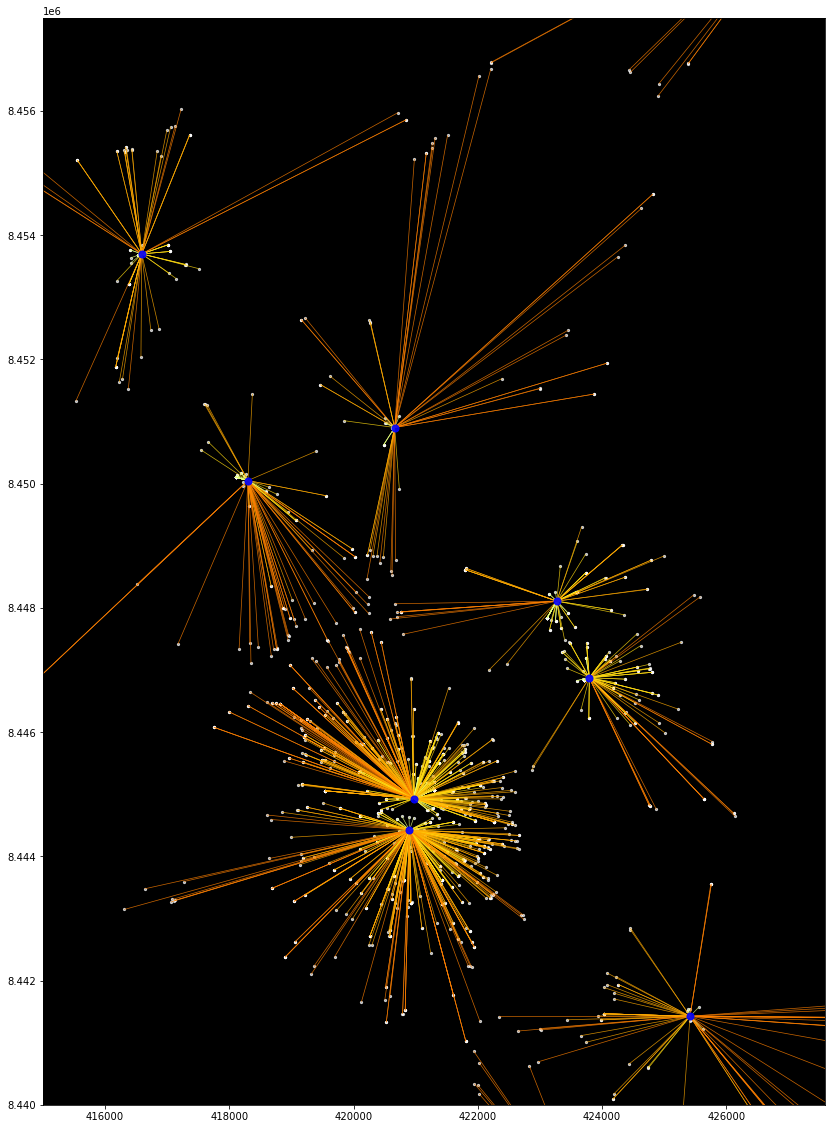

In [24]:
# Trazando las distancia, colegios y comisarias
ax = gdfColToCom.plot(column='distancia'
                      , cmap='Wistia'
                      , scheme='quantiles'
                      , figsize=(20, 20)
                      , k=4
                      , alpha=0.8
                      , lw=0.7
                     )

ax = gdfColegiosIca.plot(ax=ax
                         , color='white'
                         , markersize=5
                         , alpha=0.7
                        )

ax = gdfComisariasIca.plot(ax=ax
                           , markersize=50
                           , color='blue'
                           , alpha=0.9
                           , zorder=3)

# Haciendo zoom a una zona
ax.set_xlim([415000, 427591])
ax.set_ylim([8440000, 8457500])

# Color del fondo
ax.set_facecolor('black')

### Elaborador por:

* **Autor**: Charlie Lopez Rengifo
* **Correo**: chlopezgis@gmail.com
* **Linkedin**: [chlopezgis](https://www.linkedin.com/in/chlopezgis/)

### Referencias

* Documentación [Geopandas](https://geopandas.org/en/stable/index.html)
* Documentación [Shapely](https://shapely.readthedocs.io/en/stable/manual.html)
* Curso [Automating GIS-processes (University of Helsinki)](https://autogis-site.readthedocs.io/en/latest/index.html)